In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import re

## LOAD THE DATASETS##
detection_data = pd.read_csv(r"C:\Users\Yaser\Desktop\soulpage\Licplatesdetection_train.csv")
recognition_data = pd.read_csv(r"C:\Users\Yaser\Desktop\soulpage\Licplatesrecognition_train.csv")

# PATHS TO IMAGES#
detection_image_path = r"C:\Users\Yaser\Desktop\soulpage\license_plates_detection_train"
recognition_image_path = r"C:\Users\Yaser\Desktop\soulpage\license_plates_recognition_train"

In [2]:
# LOAD DETECTION IMAGES AND BOUNDING BOX COORDINATES
detection_images = []
detection_bboxes = []
for idx, row in detection_data.iterrows():
    img_path = os.path.join(detection_image_path, row['img_id'])
    img = cv2.imread(img_path)
    detection_images.append(cv2.resize(img, (128, 128)))
    detection_bboxes.append([row['ymin'], row['xmin'], row['ymax'], row['xmax']])

detection_images = np.array(detection_images)
detection_bboxes = np.array(detection_bboxes)

In [3]:
#LOAD RECOGNITION IMAGES
recognition_images = []
for filename in recognition_data['img_id']:
    img_path = os.path.join(recognition_image_path, filename)
    img = cv2.imread(img_path)
    recognition_images.append(cv2.resize(img, (128, 128)))

recognition_images = np.array(recognition_images)

In [4]:
# PRE PROCESS RECOGNITION LABELS
def filter_valid_labels(dataframe, column):
    alphanumeric_pattern = re.compile(r'^[A-Z0-9]+$')
    valid_data = dataframe[dataframe[column].apply(lambda x: bool(alphanumeric_pattern.match(x)))]
    return valid_data

# FILTER RECOGNITION DATA TO ONLY INCLUDE ROWS WITH VALID LICENSE PLATE TEXT (ALPHANUMERIC)
recognition_data_filtered = filter_valid_labels(recognition_data, 'text')

In [5]:
# Define manual label mapping
alphanumeric_chars = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
label_mapping = {char: i for i, char in enumerate(alphanumeric_chars)}

# Convert text data to labels
recognition_labels = []
for text in recognition_data_filtered['text']:
    label = [label_mapping[char] for char in text]
    recognition_labels.append(label)

# Pad labels to fixed length (assuming max length is 10)
max_length = 10
padded_recognition_labels = []
for label in recognition_labels:
    padded_label = label + [0] * (max_length - len(label))
    padded_recognition_labels.append(padded_label)

# One-hot encode labels
recognition_labels = np.array(padded_recognition_labels)
recognition_labels_onehot = np.zeros((len(recognition_labels), max_length, 36))  # Initialize one-hot array
for i, label in enumerate(recognition_labels):
    for j, idx in enumerate(label):
        recognition_labels_onehot[i, j, idx] = 1

# Use the one-hot encoded labels
recognition_labels = recognition_labels_onehot  

In [6]:
# Update the images accordingly by filtering them as per the valid recognition_data
recognition_images_filtered = recognition_images[:len(recognition_data_filtered)]

# Split the filtered recognition dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(recognition_images_filtered, recognition_labels, test_size=0.2, random_state=42)

In [8]:
# Import necessary layers
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Dropout, Reshape

# Define the model for recognition
def build_recognition_model(input_shape):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10*36, activation='softmax'))
    model.add(Reshape((10, 36)))  # Now Reshape is defined
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Train the recognition model
recognition_model = build_recognition_model(X_train.shape[1:])
recognition_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 57600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       7,372,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 360)                 │          46,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 10, 36)              │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,438,760 (28.38 MB)

 Trainable params: 7,438,760 (28.38 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Train the model
recognition_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)

Epoch 1/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 165ms/step - accuracy: 0.2465 - loss: nan - val_accuracy: 0.2933 - val_loss: nan
Epoch 2/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 155ms/step - accuracy: 0.2910 - loss: nan - val_accuracy: 0.2933 - val_loss: nan
Epoch 3/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 155ms/step - accuracy: 0.2879 - loss: nan - val_accuracy: 0.2933 - val_loss: nan
Epoch 4/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 154ms/step - accuracy: 0.2841 - loss: nan - val_accuracy: 0.2933 - val_loss: nan
Epoch 5/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 159ms/step - accuracy: 0.2871 - loss: nan - val_accuracy: 0.2933 - val_loss: nan
Epoch 6/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 157ms/step - accuracy: 0.2865 - loss: nan - val_accuracy: 0.2933 - val_loss: nan
Epoch 7/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 155ms/step - accuracy: 0.2825 - loss: nan - val_accuracy: 0.2933 - val_loss: nan
Epoch 8/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 159ms/step - accuracy: 0.2901 - loss: nan - val_accuracy: 0.2933 - val_loss: nan
Epoch 9/10
23/23 ━━━━━━━

In [10]:
# Evaluate the model
val_loss, val_acc = recognition_model.evaluate(X_val, y_val)
print(f"Validation Accuracy: {val_acc * 100:.2f}%")

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.2932 - loss: nan
Validation Accuracy: 29.33%


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


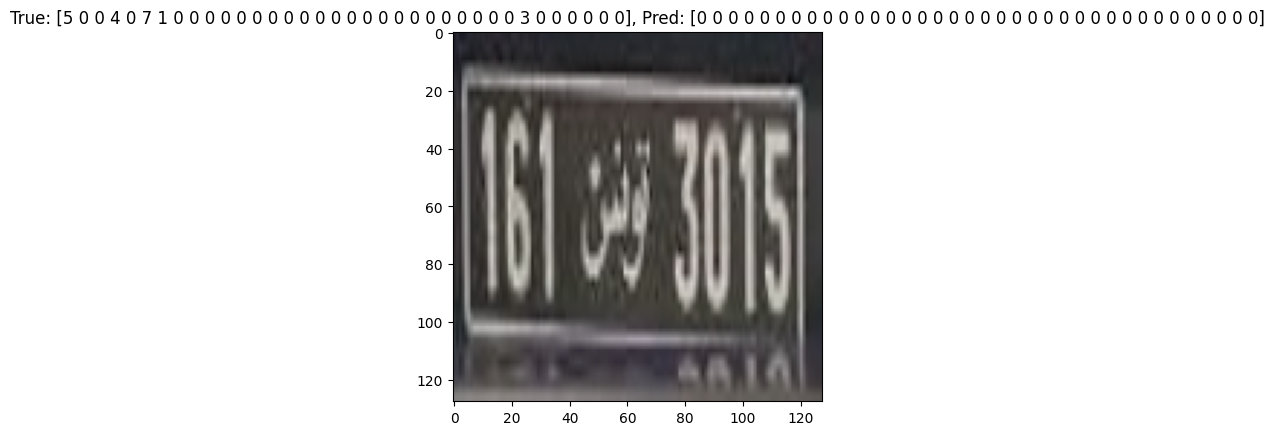

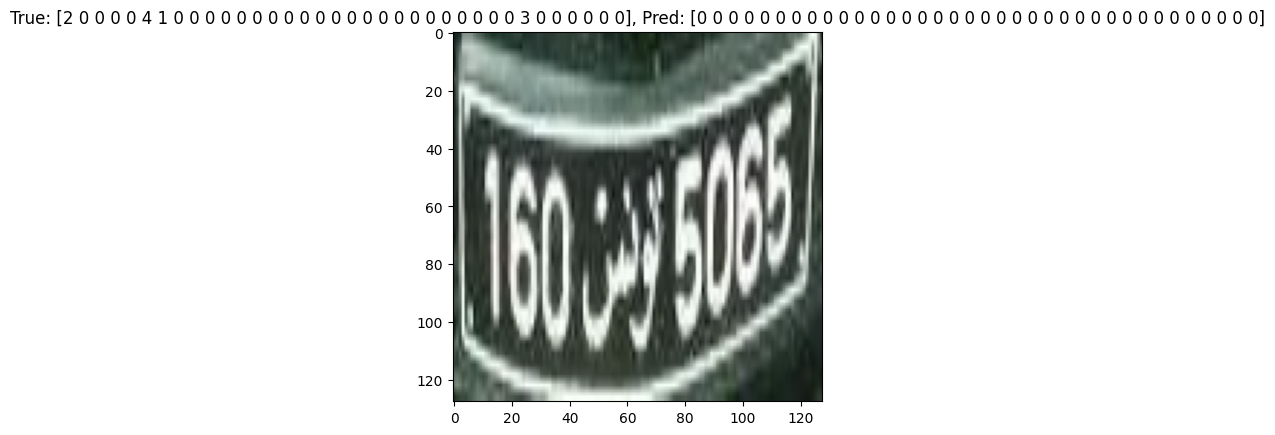

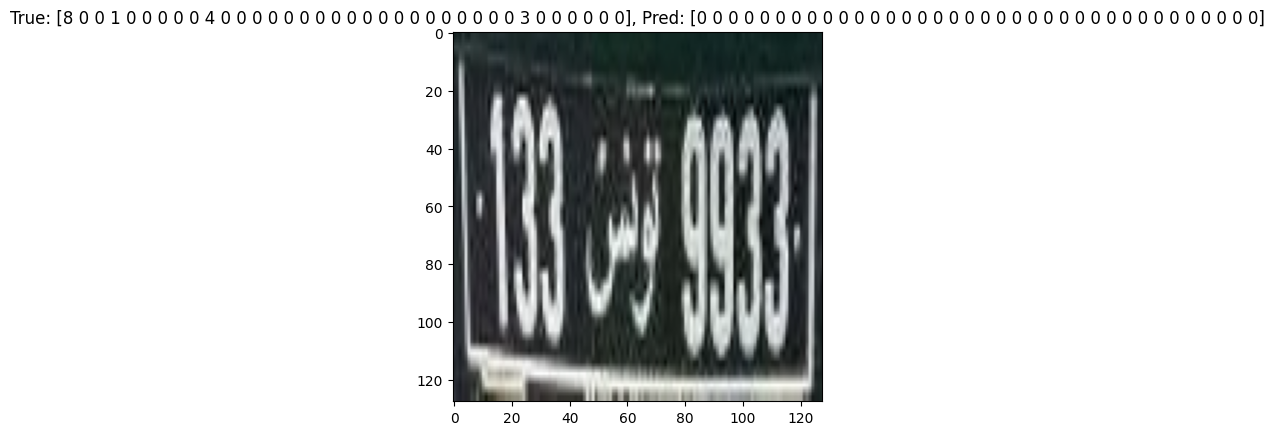

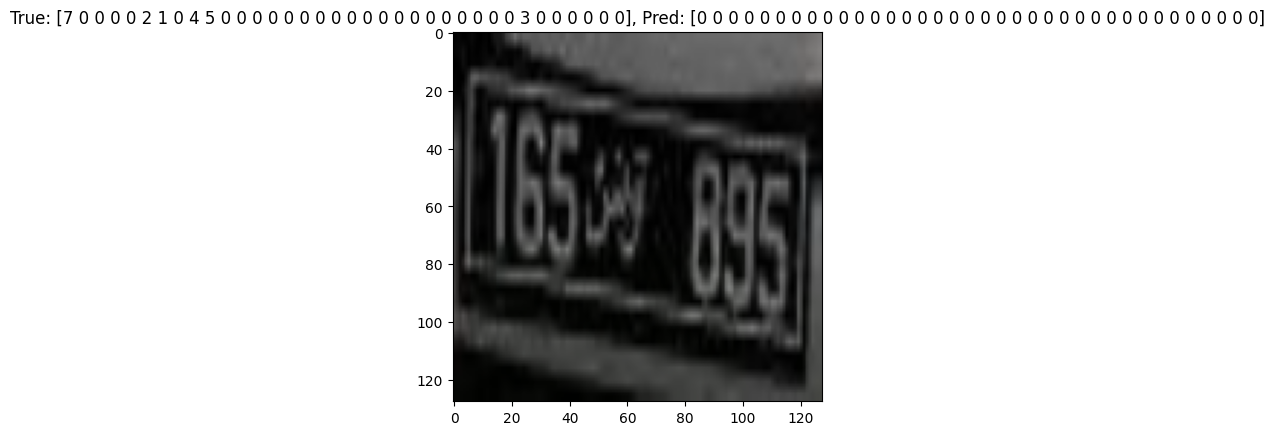

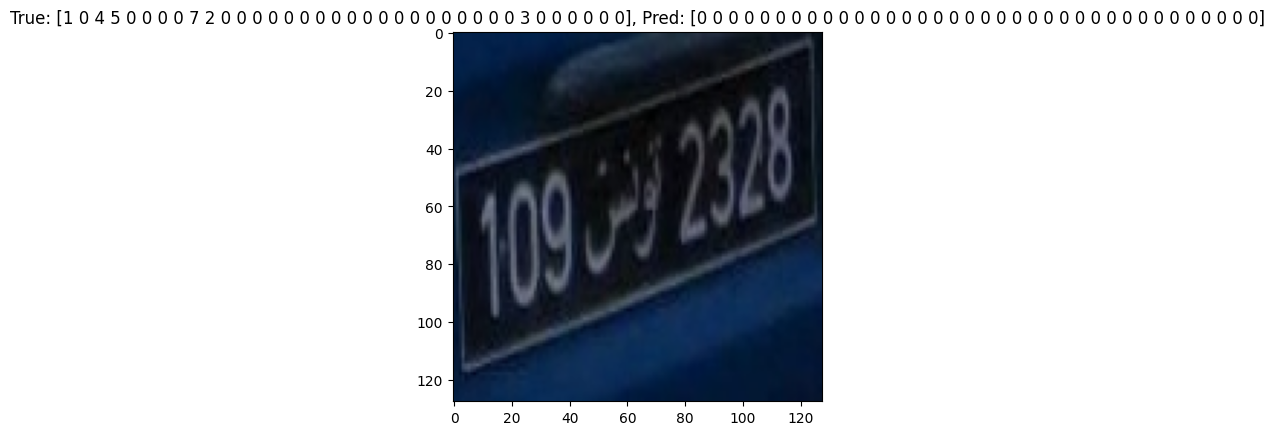

In [11]:
# Visualize some predictions
def show_sample_predictions(model, X_val, y_val):
    predictions = model.predict(X_val)
    pred_labels = np.argmax(predictions, axis=1)
    true_labels = np.argmax(y_val, axis=1)
    for i in range(5):
        plt.imshow(X_val[i])
        plt.title(f"True: {true_labels[i]}, Pred: {pred_labels[i]}")
        plt.show()

show_sample_predictions(recognition_model, X_val, y_val)